# Food Classification with PyTorch (torchvision)
Here, I will work on a project that is based on classifying up to 101 foods based on the Food-101 dataset found              here -> https://www.kaggle.com/datasets/dansbecker/food-101. 

In [ ]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import torch
from   torch import nn

torch.__version__

'2.0.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Thu Aug 31 17:37:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
| 35%   49C    P0              34W / 170W |    997MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#  Getting the data and loading it properly


In [4]:
import zipfile
from pathlib import Path
#"C:\Users\ferna\Jupyter_Files\Food-Classification\Data\food-101.zip"
# the zip file of the data where our data is in
data_path = Path("Data/")
DATA_PATH_ZIP = data_path / "food-101.zip"
DATA_PATH = data_path / "food-101"

# Check if the file is already there-> if it is no need to download anything-> if it isn't -> see if the zip file is there
# -> if it isn't please look at the link given to download the data. The zipfile is rather large!



if DATA_PATH.is_dir():
    print(f"{DATA_PATH} directory is there. No need to download")
    
else:
    print(f"{DATA_PATH} was not found -> download from {DATA_PATH_ZIP}...")
    DATA_PATH.mkdir(parents=True, exist_ok=True)
    try:
        with zipfile.ZipFile(DATA_PATH_ZIP, "r") as zip_ref:
            print(f"Unzipping {DATA_PATH_ZIP}")
            zip_ref.extractall(DATA_PATH)
    except:
        print(f"Failure in the unzipping process! see if {DATA_PATH_ZIP} or {DATA_PATH} are set appropiately")
        print("If they are...see if you have the zip file->look at the README for information regarding the data!")

    

Data\food-101 directory is there. No need to download


In [5]:
import os


FOOD_DATA_PATH = DATA_PATH / "images"

def walk_thru_dir(dir_path):
  """ Walks through dir_path returing its contents...."""
  print(f"The path given was {dir_path}")

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} in {dirpath}.")


walk_thru_dir(FOOD_DATA_PATH)

The path given was Data\food-101\images
there are 101 directories and 1 in Data\food-101\images.
there are 0 directories and 1000 in Data\food-101\images\apple_pie.
there are 0 directories and 1000 in Data\food-101\images\baby_back_ribs.
there are 0 directories and 1000 in Data\food-101\images\baklava.
there are 0 directories and 1000 in Data\food-101\images\beef_carpaccio.
there are 0 directories and 1000 in Data\food-101\images\beef_tartare.
there are 0 directories and 1000 in Data\food-101\images\beet_salad.
there are 0 directories and 1000 in Data\food-101\images\beignets.
there are 0 directories and 1000 in Data\food-101\images\bibimbap.
there are 0 directories and 1000 in Data\food-101\images\bread_pudding.
there are 0 directories and 1000 in Data\food-101\images\breakfast_burrito.
there are 0 directories and 1000 in Data\food-101\images\bruschetta.
there are 0 directories and 1000 in Data\food-101\images\caesar_salad.
there are 0 directories and 1000 in Data\food-101\images\cann

## Load the data into train/test folders with all 101 foods split 75/25

In [6]:
# run the command if you do not have the split-folders library
# It will add to your directory a train/test split datafolder so do not run this again by accident! only do it once
# Make sure your directories are set correctly
# Comment out the code for complete safety if you already have the files 


# !pip3 install split-folders
run_again = False
input_dir = "Data/food-101/images"
output_dir = "Data/food-101/images-split"

if run_again:
    import splitfolders
    if Path(output_dir).is_dir():
        print(f"split folder {output_dir} was found...will not perform any splitting train/test")
    else:
        # splits the data 75/25-> can be changed! make sure that the output_dir isn't there!
        splitfolders.ratio(input_dir, output=output_dir, seed=2, ratio=(0.75, 0.25))
else:
    print(f"run_again set to {run_again}. Will not run the code to split the folders appropiately...")


run_again set to False. Will not run the code to split the folders appropiately...


In [14]:
walk_thru_dir(output_dir)

The path given was Data/food-101/images-split
there are 2 directories and 0 in Data/food-101/images-split.
there are 101 directories and 0 in Data/food-101/images-split\train.
there are 0 directories and 750 in Data/food-101/images-split\train\apple_pie.
there are 0 directories and 750 in Data/food-101/images-split\train\baby_back_ribs.
there are 0 directories and 750 in Data/food-101/images-split\train\baklava.
there are 0 directories and 750 in Data/food-101/images-split\train\beef_carpaccio.
there are 0 directories and 750 in Data/food-101/images-split\train\beef_tartare.
there are 0 directories and 750 in Data/food-101/images-split\train\beet_salad.
there are 0 directories and 750 in Data/food-101/images-split\train\beignets.
there are 0 directories and 750 in Data/food-101/images-split\train\bibimbap.
there are 0 directories and 750 in Data/food-101/images-split\train\bread_pudding.
there are 0 directories and 750 in Data/food-101/images-split\train\breakfast_burrito.
there are 0 

In [8]:
# Load all the images from the path output_dir=Data/food-101/images-split and get a list of all images in it
output_dir = Path(output_dir)
image_path_list = list(output_dir.glob("*/*/*.jpg"))

random image path: Data\food-101\images-split\train\macaroni_and_cheese\347046.jpg
Image class macaroni_and_cheese
height: 307
width: 512


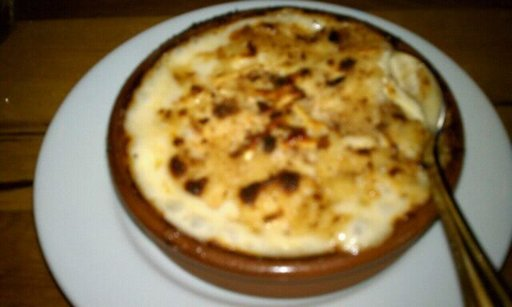

In [9]:
import random
from   PIL    import Image

# look at a random image and get its class
rdm_image = random.choice(image_path_list)
image_class = rdm_image.parent.stem
image = Image.open(rdm_image)

# Some data regarding the image and the image
print(f"random image path: {rdm_image}")
print(f"Image class {image_class}")
print(f"height: {image.height}")
print(f"width: {image.width}")
image

## Analyzing the data to see its information regarding the images such as height/width

In [10]:
# Takes a while to run (this is to do some data analyzing before turning to tensors to see an optimal size of transformation)
# Ran some data analysis in the next cell
import numpy as np

image_np = np.asarray(image)
image_np.shape

# To get some information regarding our data -> Turned into np arrays into a list
def img_to_np(image): 
    return np.asarray(Image.open(image))

np_list = list(map(img_to_np, image_path_list))

np_list

[array([[[59, 59, 49],
         [60, 60, 50],
         [60, 60, 52],
         ...,
         [48, 47, 42],
         [49, 48, 43],
         [48, 47, 42]],
 
        [[54, 55, 47],
         [55, 56, 48],
         [57, 58, 52],
         ...,
         [32, 33, 27],
         [38, 37, 32],
         [46, 47, 41]],
 
        [[40, 45, 38],
         [42, 47, 40],
         [45, 50, 44],
         ...,
         [23, 26, 19],
         [28, 29, 23],
         [39, 42, 35]],
 
        ...,
 
        [[54, 60, 32],
         [59, 63, 38],
         [64, 63, 45],
         ...,
         [44, 39, 35],
         [44, 39, 35],
         [44, 39, 35]],
 
        [[63, 68, 36],
         [66, 69, 42],
         [68, 65, 46],
         ...,
         [43, 38, 34],
         [42, 37, 33],
         [41, 36, 32]],
 
        [[66, 72, 38],
         [69, 72, 43],
         [72, 70, 49],
         ...,
         [41, 36, 32],
         [40, 35, 31],
         [39, 34, 30]]], dtype=uint8),
 array([[[ 65,  51,  16],
         [ 71,  

In [11]:
# We have over 101,000 datapoints for reference. They are in datatype uint8 0-255 so we might have to normalize it when it gets
# transformed into a tensor
width = 0
height = 0
#(H, W, C)
lowest_h = 500
lowest_w = 600
highest_h = 0
highest_w = 0


for x in np_list:
    height += x.shape[0]
    width += x.shape[1]
    lowest_h = min(lowest_h, x.shape[0])
    lowest_w = min(lowest_w, x.shape[1])
    highest_h = max(highest_h, x.shape[0])
    highest_w = max(highest_w, x.shape[1])

    
average_h = float(height) / len(np_list)
average_w = float(width) / len(np_list)

print(f"Average height: {average_h:4f}\n Average width: {average_w:4f}")
print(f"Lowest height: {lowest_h}\n Lowest width: {lowest_w}")
print(f"Highest height: {highest_h}\n Highest width: {highest_w}")


Average height: 475.372129
 Average width: 495.791396
Lowest height: 122
 Lowest width: 193
Highest height: 512
 Highest width: 512


# Transforming data into tensors, proper datasets and DataLoaders with data augmentation

### The transform that will be applied to each image (train/test)

In [12]:
from torchvision import transforms

# First Ver. resize size=(122,154)


# The transformation that our training data will go through
train_transform = transforms.Compose([
    transforms.Resize(size=(122,154)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
# test transformation (change the size and to tensor only)
test_transform = transforms.Compose([
    transforms.Resize(size=(122,154)),
    transforms.ToTensor()
])

In [13]:
# Setting up the directory path for train and test
train_dir = output_dir / "train"
test_dir = output_dir / "val"


print(f"train directory: |{train_dir}|\ntest directory:  |{test_dir}|")

train directory: |Data\food-101\images-split\train|
test directory:  |Data\food-101\images-split\val|


In [14]:
from torchvision import datasets

train_data_augment = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data_augment =  datasets.ImageFolder(root=test_dir,  transform=test_transform)

In [15]:
# Turn Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = max(1, os.cpu_count() - 4) # I have 12, though in the occasion it goes lower than 0 -> max 1 (can be changed)

torch.manual_seed(42)

train_dataloader = DataLoader(dataset=train_data_augment,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data_augment,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS)

In [18]:
# !pip3 install import-ipynb

In [24]:
# if needed run the command above to use the following cell. Otherwise, if you do not have the module then it
# will not be able to import functions from `model.ipynb` 
import import_ipynb
import model
# This is to see if a function is able to be called successfully from `model.ipynb`
rdm()

You were able to access a function within `model.ipynb`
